# Business Case 2 

### Modellbildung und Evaluation

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set()

ModuleNotFoundError: No module named 'pandas'

Importieren des Datensatzes, welcher im "Data Prep" Notebook exportiert wurde:

In [2]:
data_prepared = pd.read_csv('data_prepared.csv')

In [3]:
data_prepared

,Fluglinie,Start,Startzeit,Stops,Ankunftszeit,Ziel,Klasse,Kauf,Buchung,Source,OnlineTime,PreisTicket
0,Delta,Hamburg,Abend,zero,Nacht,Köln,Economy,1.0,1.0,Search,Spontan,595.3
1,Delta,Hamburg,Frühmorgen,zero,Morgen,Köln,Economy,1.0,1.0,Direct,Kurz,595.3
2,Lufthansa,Hamburg,Frühmorgen,zero,Frühmorgen,Köln,Economy,1.0,1.0,Social,Spontan,595.6
3,KLM,Hamburg,Morgen,zero,Nachmittag,Köln,Economy,1.0,1.0,Ads,Mittel,595.5
4,KLM,Hamburg,Morgen,zero,Morgen,Köln,Economy,1.0,1.0,Search,Kurz,595.5
...,...,...,...,...,...,...,...,...,...,...,...,...
294886,RyanAir,Nürnberg,Abend,one,Morgen,Frankfurt,Business,0.0,49.0,Direct,Lang,5134.5
294887,RyanAir,Nürnberg,Morgen,one,Morgen,Frankfurt,Business,0.0,49.0,Social,Lang,5134.5
294888,RyanAir,Nürnberg,Frühmorgen,one,Morgen,Frankfurt,Business,0.0,49.0,Direct,Kurz,5134.5
294889,RyanAir,Nürnberg,Frühmorgen,one,Nacht,Frankfurt,Business,0.0,49.0,Ads,Lang,6873.9


### Check Oversampling der Zielvariable

In [4]:
# Analyse der Zielvariable 

"""
zielvariable_counts = data_prepared['Zielvariable'].value_counts()
print(zielvariable_counts)

zielvariable_counts.plot(kind='bar')
plt.xlabel('Zielvariable')
plt.ylabel('Count')
plt.title('Distribution of Zielvariable')
plt.show()
"""

"\nzielvariable_counts = data_prepared['Zielvariable'].value_counts()\nprint(zielvariable_counts)\n\nzielvariable_counts.plot(kind='bar')\nplt.xlabel('Zielvariable')\nplt.ylabel('Count')\nplt.title('Distribution of Zielvariable')\nplt.show()\n"

### Dummy Variablen erstellen

In [5]:
data_dummies = pd.get_dummies(data_prepared, drop_first=True)
data_dummies.head()

,Kauf,Buchung,PreisTicket,Fluglinie_Delta,Fluglinie_KLM,Fluglinie_Lufthansa,Fluglinie_RyanAir,Fluglinie_United,Start_Frankfurt,Start_Hamburg,...,Ziel_Köln,Ziel_München,Ziel_Nürnberg,Klasse_Economy,Source_Direct,Source_Search,Source_Social,OnlineTime_Lang,OnlineTime_Mittel,OnlineTime_Spontan
0,1.0,1.0,595.3,1,0,0,0,0,0,1,...,1,0,0,1,0,1,0,0,0,1
1,1.0,1.0,595.3,1,0,0,0,0,0,1,...,1,0,0,1,1,0,0,0,0,0
2,1.0,1.0,595.6,0,0,1,0,0,0,1,...,1,0,0,1,0,0,1,0,0,1
3,1.0,1.0,595.5,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
4,1.0,1.0,595.5,0,1,0,0,0,0,1,...,1,0,0,1,0,1,0,0,0,0


### Auf Multikollinearität prüfen

In [6]:
# Spaltennamen ausgeben
spalten = data_dummies.columns.to_list()

print(spalten)

['Kauf', 'Buchung', 'PreisTicket', 'Fluglinie_Delta', 'Fluglinie_KLM', 'Fluglinie_Lufthansa', 'Fluglinie_RyanAir', 'Fluglinie_United', 'Start_Frankfurt', 'Start_Hamburg', 'Start_Köln', 'Start_München', 'Start_Nürnberg', 'Startzeit_Frühmorgen', 'Startzeit_Late_Night', 'Startzeit_Morgen', 'Startzeit_Nachmittag', 'Startzeit_Night', 'Stops_two_or_more', 'Stops_zero', 'Ankunftszeit_Frühmorgen', 'Ankunftszeit_Late_Nacht', 'Ankunftszeit_Morgen', 'Ankunftszeit_Nachmittag', 'Ankunftszeit_Nacht', 'Ziel_Frankfurt', 'Ziel_Hamburg', 'Ziel_Köln', 'Ziel_München', 'Ziel_Nürnberg', 'Klasse_Economy', 'Source_Direct', 'Source_Search', 'Source_Social', 'OnlineTime_Lang', 'OnlineTime_Mittel', 'OnlineTime_Spontan']


In [7]:
# Faustregel --> ein VIF > 10 deutet auf hohe Multikollinearität hin

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Deklarieren eines data frames und Eingabe aller Merkmale, die auf Multikollinearität geprüft werden sollen.
variables = data_dummies[['Buchung', 'PreisTicket', 'Fluglinie_Delta', 'Fluglinie_KLM', 'Fluglinie_Lufthansa', 'Fluglinie_RyanAir', 'Fluglinie_United', 'Start_Frankfurt', 'Start_Hamburg', 'Start_Köln', 'Start_München', 'Start_Nürnberg', 'Startzeit_Frühmorgen', 'Startzeit_Late_Night', 'Startzeit_Morgen', 'Startzeit_Nachmittag', 'Startzeit_Night', 'Stops_two_or_more', 'Stops_zero', 'Ankunftszeit_Frühmorgen', 'Ankunftszeit_Late_Nacht', 'Ankunftszeit_Morgen', 'Ankunftszeit_Nachmittag', 'Ankunftszeit_Nacht', 'Ziel_Frankfurt', 'Ziel_Hamburg', 'Ziel_Köln', 'Ziel_München', 'Ziel_Nürnberg', 'Klasse_Economy', 'Source_Direct', 'Source_Search', 'Source_Social', 'OnlineTime_Lang', 'OnlineTime_Mittel', 'OnlineTime_Spontan']]

# Erstellen eines neuen data frames, der alle VIFs enthält.
# Jede Variable hat ihren eigenen Varianzinflationsfaktor. Dieses Maß ist variablenspezifisch
vif = pd.DataFrame()

# Verwendung des Moduls variance_inflation_factor, Ausgabe der jeweiligen VIFs
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

# Einfügen von Variablennamen
vif["Features"] = variables.columns

# Ausgabe der Ergebnisse
vif = vif.sort_values(by='VIF', ascending=False)
vif

,VIF,Features
29,13.101008,Klasse_Economy
1,8.546897,PreisTicket
3,6.875992,Fluglinie_KLM
0,4.987428,Buchung
5,4.370623,Fluglinie_RyanAir
33,2.844547,OnlineTime_Lang
6,2.788336,Fluglinie_United
31,2.593441,Source_Search
34,2.362457,OnlineTime_Mittel
9,2.325695,Start_Köln


In [8]:
data_dummies = data_dummies.drop('Klasse_Economy', axis=1)

In [9]:
# Faustregel --> ein VIF > 10 deutet auf hohe Multikollinearität hin

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Deklarieren eines data frames und Eingabe aller Merkmale, die auf Multikollinearität geprüft werden sollen.
variables = data_dummies[['Buchung', 'PreisTicket', 'Fluglinie_Delta', 'Fluglinie_KLM', 'Fluglinie_Lufthansa', 'Fluglinie_RyanAir', 'Fluglinie_United', 'Start_Frankfurt', 'Start_Hamburg', 'Start_Köln', 'Start_München', 'Start_Nürnberg', 'Startzeit_Frühmorgen', 'Startzeit_Late_Night', 'Startzeit_Morgen', 'Startzeit_Nachmittag', 'Startzeit_Night', 'Stops_two_or_more', 'Stops_zero', 'Ankunftszeit_Frühmorgen', 'Ankunftszeit_Late_Nacht', 'Ankunftszeit_Morgen', 'Ankunftszeit_Nachmittag', 'Ankunftszeit_Nacht', 'Ziel_Frankfurt', 'Ziel_Hamburg', 'Ziel_Köln', 'Ziel_München', 'Ziel_Nürnberg', 'Source_Direct', 'Source_Search', 'Source_Social', 'OnlineTime_Lang', 'OnlineTime_Mittel', 'OnlineTime_Spontan']]

# Erstellen eines neuen data frames, der alle VIFs enthält.
# Jede Variable hat ihren eigenen Varianzinflationsfaktor. Dieses Maß ist variablenspezifisch
vif = pd.DataFrame()

# Verwendung des Moduls variance_inflation_factor, Ausgabe der jeweiligen VIFs
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]

# Einfügen von Variablennamen
vif["Features"] = variables.columns

# Ausgabe der Ergebnisse
vif = vif.sort_values(by='VIF', ascending=False)
vif

,VIF,Features
3,5.823584,Fluglinie_KLM
0,4.952708,Buchung
5,3.870225,Fluglinie_RyanAir
32,2.774188,OnlineTime_Lang
1,2.639535,PreisTicket
30,2.394011,Source_Search
6,2.344469,Fluglinie_United
33,2.299207,OnlineTime_Mittel
29,2.253174,Source_Direct
8,2.178986,Start_Hamburg


# Modeling

In [11]:
# Definition der Input- und Zielvariablen
targets = data_dummies['Kauf']
inputs = data_dummies.drop(['Kauf'],axis=1)


In [12]:
# Aufteilen in  80% Trainings- und 20% Testdaten
from sklearn.model_selection import train_test_split

# Aufteilung der Daten in 80% Trainings- und 20% Testdaten
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=365)

### Standardisierung

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

### Oversampling

In [ ]:
# hier gfs. Oversampling durchführen

"""
# RandomOverSampler um Dysbalance auszugleichen

# sampling_strategy = 1.0 - erstellt ein 1:1 Verhältnis von 1 und 0 in den Trainingsdaten
ros =  RandomOverSampler(sampling_strategy=1.0, random_state=42)

x_train_res, y_train_res = ros.fit_resample(x_train, y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))


x_train = x_train_res
y_train = y_train_res
"""

## Modellbildung Logistische Regression

#### Model Creation

In [16]:
# Modell erstellen
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)

c:\Users\176137724\Anaconda3\envs\Datathon\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

#### Hyperparameter Optimization

In [17]:
"""
# Definition der Hyperparameter und ihrer möglichen Werte für die randomisierte Suche
param_distributions = {
    'C': [0.1, 1.0, 10.0], # Regularisierungsstärke 
}

# Erstellung des Modellbewerters basierend auf dem F1-Score
scorer = make_scorer(f1_score)

# Erstellung des RandomizedSearchCV mit F1-Score als Bewertungsmaßstab
grid_search  = GridSearchCV(model_lr, param_distributions, scoring=scorer, cv=5)

# Randomized Search durchführen
grid_search.fit(x_train, y_train)

# Die besten Hyperparameter und das beste Modell ausgeben
best_params = grid_search.best_params_
model_lr = grid_search.best_estimator_

# Bewertung des besten Modells anhand den Testdaten
print("Best hyperparameters:", best_params)
"""


'\n# Definition der Hyperparameter und ihrer möglichen Werte für die randomisierte Suche\nparam_distributions = {\n    \'C\': [0.1, 1.0, 10.0], # Regularisierungsstärke \n}\n\n# Erstellung des Modellbewerters basierend auf dem F1-Score\nscorer = make_scorer(f1_score)\n\n# Erstellung des RandomizedSearchCV mit F1-Score als Bewertungsmaßstab\ngrid_search  = GridSearchCV(model_lr, param_distributions, scoring=scorer, cv=5)\n\n# Randomized Search durchführen\ngrid_search.fit(x_train, y_train)\n\n# Die besten Hyperparameter und das beste Modell ausgeben\nbest_params = grid_search.best_params_\nmodel_lr = grid_search.best_estimator_\n\n# Bewertung des besten Modells anhand den Testdaten\nprint("Best hyperparameters:", best_params)\n'

#### Evaluation

In [18]:
# Werte vorhersagen
predictions_lr_train = model_lr.predict(x_train)
predictions_lr_test = model_lr.predict(x_test)

##### Confusion matrix

In [19]:
# confusion matrix erstellen für train data
cm = confusion_matrix(y_train, predictions_lr_train)
print(cm)

[[115596   1144]
 [   610 118562]]


In [20]:
# confusion matrix erstellen für test data
cm = confusion_matrix(y_test, predictions_lr_test)
print(cm)

[[28717   318]
 [  156 29788]]


In [21]:
print("Trainingsdaten Logistic Regression:")
print(classification_report(y_train, predictions_lr_train))
print("--------------------------------------------------------")
print("Testdaten Logistic Regression:")
print(classification_report(y_test, predictions_lr_test))

Trainingsdaten Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    116740
         1.0       0.99      0.99      0.99    119172

    accuracy                           0.99    235912
   macro avg       0.99      0.99      0.99    235912
weighted avg       0.99      0.99      0.99    235912

--------------------------------------------------------
Testdaten Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     29035
         1.0       0.99      0.99      0.99     29944

    accuracy                           0.99     58979
   macro avg       0.99      0.99      0.99     58979
weighted avg       0.99      0.99      0.99     58979



##### Check Feature importance

[-1.59687766e+01 -1.56619478e+01 -4.00700415e+00 -3.50864766e+00
 -1.39771757e+00 -1.32960735e+00 -1.02332256e+00 -1.02088287e+00
 -8.54200263e-01 -7.57802246e-01 -4.33721887e-01 -2.03809896e-01
 -1.85068833e-01 -1.64319032e-01 -1.40442144e-01 -1.10535929e-01
 -6.68168568e-02 -5.50294326e-02 -5.56032954e-03  1.33535327e-02
  4.28154683e-02  6.83711850e-02  7.23623237e-02  1.10434970e-01
  1.12299650e-01  3.01061123e-01  6.12508797e-01  9.65813940e-01
  1.10538981e+00  1.11639176e+00  1.68181902e+00  2.35572822e+00
  3.19916011e+00  3.82124362e+00  3.96638453e+00]


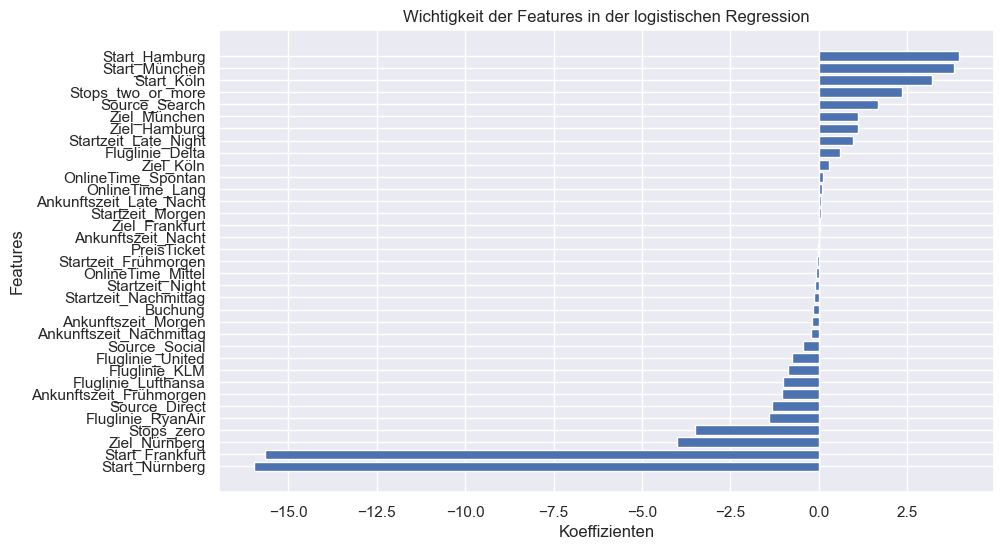

In [22]:
coefficients = model_lr.coef_[0]
feature_names = np.array(x_train.columns)

# Sortieren der Koeffizienten nach ihrer Wichtigkeit
sorted_indices = np.argsort(coefficients)
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

print(sorted_coefficients)

# Darstellung der Wichtigkeit der Features
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_coefficients)
plt.xlabel("Koeffizienten")
plt.ylabel("Features")
plt.title("Wichtigkeit der Features in der logistischen Regression")
plt.show()

## Modellbildung Decision Tree

#### Model Creation

In [23]:
# Modell erstellen mit fixem random_state (ermöglicht die Reproduzierbarkeit von zufälligen Abläufen oder Zufallsgenerierungen)
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

#### Hyperparameter Optimization

In [ ]:
"""
# Definition der Hyperparameter und ihrer möglichen Werte für die randomisierte Suche
param_distributions = {
    'max_depth': [3, 5, 7, None],       # maximale Tiefe des Entscheidungsbaums
    'min_samples_split': [2, 5, 10],    # Minimale Anzahl von Proben für einen Split
    'min_samples_leaf': [1, 2, 4],      # Minimale Anzahl von Proben in einem Blatt
    'criterion': ['gini', 'entropy']    # Kriterium für die Aufteilung
}

# Erstellung des Modellbewerters basierend auf dem F1-Score
scorer = make_scorer(f1_score)

# Erstellung des RandomizedSearchCV mit F1-Score als Bewertungsmaßstab
grid_search  = GridSearchCV(model_dt, param_distributions, scoring=scorer, cv=5)

# Randomized Search durchführen
grid_search.fit(x_train, y_train)

# Ermittlung der besten Hyperparameter und des besten Modells
best_params = grid_search.best_params_
model_dt = grid_search.best_estimator_

# beste Hyperparameter ausgeben
print("Best hyperparameters:", best_params)

"""


'\n# Definition der Hyperparameter und ihrer möglichen Werte für die randomisierte Suche\nparam_distributions = {\n    \'C\': [0.1, 1.0, 10.0], # Regularisierungsstärke \n}\n\n# Erstellung des Modellbewerters basierend auf dem F1-Score\nscorer = make_scorer(f1_score)\n\n# Erstellung des RandomizedSearchCV mit F1-Score als Bewertungsmaßstab\ngrid_search  = GridSearchCV(model_lr, param_distributions, scoring=scorer, cv=5)\n\n# Randomized Search durchführen\ngrid_search.fit(x_train, y_train)\n\n# Die besten Hyperparameter und das beste Modell ausgeben\nbest_params = grid_search.best_params_\nmodel_lr = grid_search.best_estimator_\n\n# Bewertung des besten Modells anhand den Testdaten\nprint("Best hyperparameters:", best_params)\n'

#### Evaluation

In [24]:
# Werte vorhersagen für train data
predictions_dt_train = model_dt.predict(x_train)

# Werte vorhersagen für test data
predictions_dt_test = model_dt.predict(x_test)

##### Confusion matrix

In [25]:
# confusion matrix erstellen für train data
cm = confusion_matrix(y_train, predictions_dt_train)
print(cm)

[[116740      0]
 [     0 119172]]


In [26]:
# confusion matrix erstellen für test data
cm = confusion_matrix(y_test, predictions_dt_test)
print(cm)

[[29030     5]
 [   12 29932]]


In [27]:
print("Trainingsdaten Decision Tree:")
print(classification_report(y_train, predictions_dt_train))
print("--------------------------------------------------------")
print("Trainingsdaten Decision Tree:")
print(classification_report(y_test, predictions_dt_test))

Trainingsdaten Decision Tree:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    116740
         1.0       1.00      1.00      1.00    119172

    accuracy                           1.00    235912
   macro avg       1.00      1.00      1.00    235912
weighted avg       1.00      1.00      1.00    235912

--------------------------------------------------------
Trainingsdaten Decision Tree:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29035
         1.0       1.00      1.00      1.00     29944

    accuracy                           1.00     58979
   macro avg       1.00      1.00      1.00     58979
weighted avg       1.00      1.00      1.00     58979



##### Check Feature importance

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.65857718e-08
 7.63077467e-06 9.99392019e-06 1.02389378e-05 1.13048514e-05
 1.58974472e-05 1.67600994e-05 1.76644316e-05 2.14485546e-05
 3.31176896e-05 3.38760710e-05 4.00577428e-05 7.45092476e-05
 8.26234672e-05 1.01441175e-04 1.01777308e-04 1.52330115e-04
 2.03011129e-04 2.99502574e-04 2.73531961e-03 3.26395539e-03
 4.15912089e-03 7.25957274e-03 7.85643950e-03 1.51067259e-02
 2.31560921e-01 2.88798427e-01 4.38026246e-01]


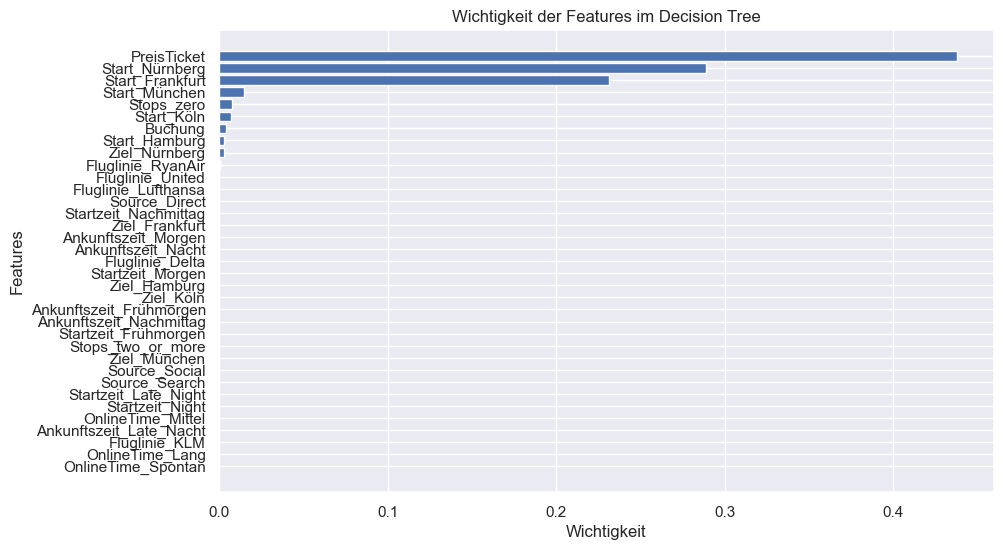

In [28]:
# Wichtigkeit der Features abrufen
importances = model_dt.feature_importances_
feature_names = np.array(x_train.columns)

# Sortieren der Features nach ihrer Wichtigkeit
sorted_indices = np.argsort(importances)
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

print(sorted_importances)

# Darstellung der Wichtigkeit der Features
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel("Wichtigkeit")
plt.ylabel("Features")
plt.title("Wichtigkeit der Features im Decision Tree")
plt.show()

## Modellbildung Random Forest

#### Model Creation

In [29]:
# Modell erstellen mit fixem random_state (ermöglicht die Reproduzierbarkeit von zufälligen Abläufen oder Zufallsgenerierungen)
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

#### Hyperparameter Optimization

In [ ]:
"""
# Definition der Hyperparameter und ihrer möglichen Werte für die randomisierte Suche
param_distributions = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Erstellung des Modellbewerters basierend auf dem F1-Score
scorer = make_scorer(f1_score)

# Erstellung des RandomizedSearchCV mit F1-Score als Bewertungsmaßstab
grid_search  = GridSearchCV(model_rf, param_distributions, scoring=scorer, cv=5)

# Randomized Search durchführen
grid_search.fit(x_train, y_train)

# Die besten Hyperparameter und das beste Modell ausgeben
best_params = grid_search.best_params_
model_rf = grid_search.best_estimator_

# Bewertung des besten Modells anhand der Testdaten
print("Best hyperparameters:", best_params)
"""

'\n# Definition der Hyperparameter und ihrer möglichen Werte für die randomisierte Suche\nparam_distributions = {\n    \'C\': [0.1, 1.0, 10.0], # Regularisierungsstärke \n}\n\n# Erstellung des Modellbewerters basierend auf dem F1-Score\nscorer = make_scorer(f1_score)\n\n# Erstellung des RandomizedSearchCV mit F1-Score als Bewertungsmaßstab\ngrid_search  = GridSearchCV(model_lr, param_distributions, scoring=scorer, cv=5)\n\n# Randomized Search durchführen\ngrid_search.fit(x_train, y_train)\n\n# Die besten Hyperparameter und das beste Modell ausgeben\nbest_params = grid_search.best_params_\nmodel_lr = grid_search.best_estimator_\n\n# Bewertung des besten Modells anhand den Testdaten\nprint("Best hyperparameters:", best_params)\n'

#### Evaluation

In [30]:
# Werte vorhersagen für train data
predictions_rf_train = model_rf.predict(x_train)

# Werte vorhersagen für test data
predictions_rf_test = model_rf.predict(x_test)

##### Confusion matrix

In [31]:
# confusion matrix erstellen für train data
cm = confusion_matrix(y_train, predictions_rf_train)
print(cm)

[[116740      0]
 [     0 119172]]


In [32]:
# confusion matrix erstellen für test data
cm = confusion_matrix(y_test, predictions_rf_test)
print(cm)

[[29010    25]
 [   23 29921]]


In [33]:
print("Trainingsdaten Random Forest:")
print(classification_report(y_train, predictions_rf_train))
print("--------------------------------------------------------")
print("Trainingsdaten Random Forest:")
print(classification_report(y_test, predictions_rf_test))

Trainingsdaten Random Forest:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    116740
         1.0       1.00      1.00      1.00    119172

    accuracy                           1.00    235912
   macro avg       1.00      1.00      1.00    235912
weighted avg       1.00      1.00      1.00    235912

--------------------------------------------------------
Trainingsdaten Random Forest:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29035
         1.0       1.00      1.00      1.00     29944

    accuracy                           1.00     58979
   macro avg       1.00      1.00      1.00     58979
weighted avg       1.00      1.00      1.00     58979



##### Check Feature importance

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.65857718e-08
 7.63077467e-06 9.99392019e-06 1.02389378e-05 1.13048514e-05
 1.58974472e-05 1.67600994e-05 1.76644316e-05 2.14485546e-05
 3.31176896e-05 3.38760710e-05 4.00577428e-05 7.45092476e-05
 8.26234672e-05 1.01441175e-04 1.01777308e-04 1.52330115e-04
 2.03011129e-04 2.99502574e-04 2.73531961e-03 3.26395539e-03
 4.15912089e-03 7.25957274e-03 7.85643950e-03 1.51067259e-02
 2.31560921e-01 2.88798427e-01 4.38026246e-01]


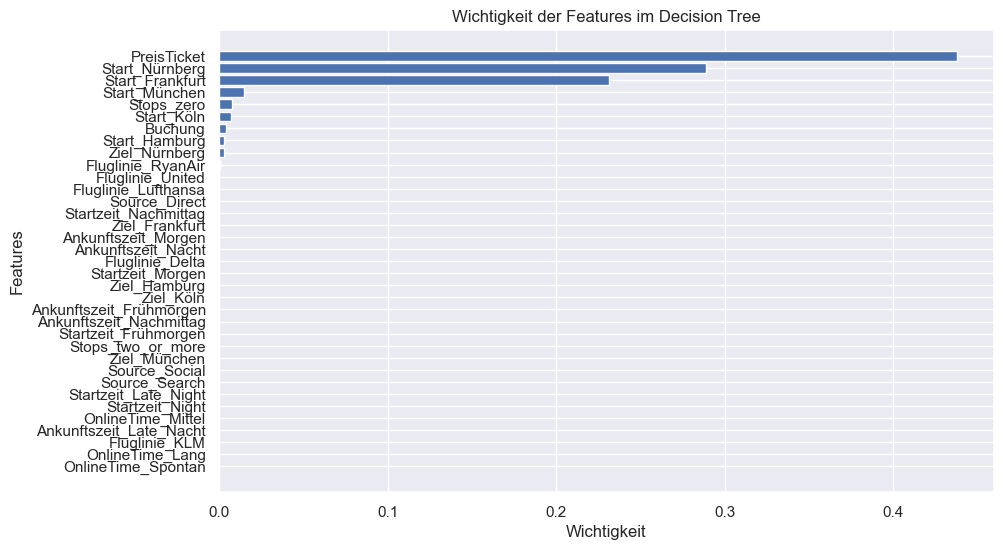

In [34]:
# Wichtigkeit der Features abrufen
importances = model_dt.feature_importances_
feature_names = np.array(x_train.columns)

# Sortieren der Features nach ihrer Wichtigkeit
sorted_indices = np.argsort(importances)
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

print(sorted_importances)

# Darstellung der Wichtigkeit der Features
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel("Wichtigkeit")
plt.ylabel("Features")
plt.title("Wichtigkeit der Features im Decision Tree")
plt.show()

## Modellbildung XGBoost

#### Model Creation

In [ ]:
#conda install xgboost

In [39]:
import xgboost as xgb

# Modell erstellen mit fixem random_state (ermöglicht die Reproduzierbarkeit von zufälligen Abläufen oder Zufallsgenerierungen)
model_xgb = xgb.XGBClassifier(random_state=42)

# XGBoost-Parameter festlegen
params = {
    'objective': 'binary:logistic',  # Binäre Klassifikation
    'eval_metric': 'logloss',        # Bewertungsmetrik (logarithmischer Verlust)
}

# Modell trainieren
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

#### Hyperparameter Optimization

In [ ]:
"""

# Parameter-Raum für die Hyperparameter-Optimierung festlegen
param_distributions = {
    'eta': [0.01, 0.1, 0.2],        # Lernrate
    'max_depth': [3, 5, 7],         # Maximale Tiefe der Entscheidungsbäume
    'min_child_weight': [1, 3, 5],  # Minimales Gewicht pro Blatt
    'gamma': [0, 0.1, 0.2],         # Minimale Reduzierung des Verlusts, die für einen Split erforderlich ist
}

# Erstellung des Modellbewerters basierend auf dem F1-Score
scorer = make_scorer(f1_score)

# Erstellung des RandomizedSearchCV mit F1-Score als Bewertungsmaßstab
grid_search  = GridSearchCV(model_xgb, param_distributions, scoring=scorer, cv=5)

# Randomized Search durchführen
grid_search.fit(x_train, y_train)

# Beste Hyperparameter und bestes Modell erhalten
best_params = grid_search.best_params_
model_xgb = grid_search.best_estimator_

# Ausgabe der besten Parameter
print("Best hyperparameters:", best_params)

"""

'\n# Definition der Hyperparameter und ihrer möglichen Werte für die randomisierte Suche\nparam_distributions = {\n    \'C\': [0.1, 1.0, 10.0], # Regularisierungsstärke \n}\n\n# Erstellung des Modellbewerters basierend auf dem F1-Score\nscorer = make_scorer(f1_score)\n\n# Erstellung des RandomizedSearchCV mit F1-Score als Bewertungsmaßstab\ngrid_search  = GridSearchCV(model_lr, param_distributions, scoring=scorer, cv=5)\n\n# Randomized Search durchführen\ngrid_search.fit(x_train, y_train)\n\n# Die besten Hyperparameter und das beste Modell ausgeben\nbest_params = grid_search.best_params_\nmodel_lr = grid_search.best_estimator_\n\n# Bewertung des besten Modells anhand den Testdaten\nprint("Best hyperparameters:", best_params)\n'

#### Evaluation

In [40]:
# Vorhersagen für Trainingsdaten machen
predictions_xgb_train = model_xgb.predict(x_train)

# Vorhersagen für Testdaten machen
predictions_xgb_test = model_xgb.predict(x_test)

# Rundungsregel anwenden, um binäre Vorhersagen zu erhalten
binary_predictions_xgb_train = [1 if p >= 0.5 else 0 for p in predictions_xgb_train]
binary_predictions_xgb_test = [1 if p >= 0.5 else 0 for p in predictions_xgb_test]

##### Confusion matrix

In [41]:
# confusion matrix erstellen für train data
cm = confusion_matrix(y_train, binary_predictions_xgb_train)
print(cm)

[[116740      0]
 [     2 119170]]


In [42]:
# confusion matrix erstellen für test data
cm = confusion_matrix(y_test, binary_predictions_xgb_test)
print(cm)

[[29034     1]
 [    6 29938]]


In [43]:
print("Trainingsdaten XGBoost:")
print(classification_report(y_train, binary_predictions_xgb_train))
print("--------------------------------------------------------")
print("Trainingsdaten XGBoost:")
print(classification_report(y_test, binary_predictions_xgb_test))

Trainingsdaten XGBoost:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    116740
         1.0       1.00      1.00      1.00    119172

    accuracy                           1.00    235912
   macro avg       1.00      1.00      1.00    235912
weighted avg       1.00      1.00      1.00    235912

--------------------------------------------------------
Trainingsdaten XGBoost:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29035
         1.0       1.00      1.00      1.00     29944

    accuracy                           1.00     58979
   macro avg       1.00      1.00      1.00     58979
weighted avg       1.00      1.00      1.00     58979



##### Check Feature importance

In [44]:
# Feature Importance abrufen
importance = model_xgb.feature_importances_

# Ausgabe der Feature Importance
for i, feature in enumerate(x_train.columns):
    print(f'{feature}: {importance[i]}')

Buchung: 0.003687983611598611
PreisTicket: 0.07572566717863083
Fluglinie_Delta: 0.0
Fluglinie_KLM: 0.00019560665532480925
Fluglinie_Lufthansa: 0.0025510068517178297
Fluglinie_RyanAir: 0.001100719440728426
Fluglinie_United: 0.0010592369362711906
Start_Frankfurt: 0.3805115520954132
Start_Hamburg: 0.016201145946979523
Start_Köln: 0.013578705489635468
Start_München: 0.009471622295677662
Start_Nürnberg: 0.45399370789527893
Startzeit_Frühmorgen: 0.00017178340931423008
Startzeit_Late_Night: 0.0
Startzeit_Morgen: 0.00015469948993995786
Startzeit_Nachmittag: 0.00021025522437412292
Startzeit_Night: 3.6290555726736784e-05
Stops_two_or_more: 0.0002370818838244304
Stops_zero: 0.009376089088618755
Ankunftszeit_Frühmorgen: 2.04183415917214e-05
Ankunftszeit_Late_Nacht: 0.0
Ankunftszeit_Morgen: 0.00011861170060001314
Ankunftszeit_Nachmittag: 7.144546543713659e-05
Ankunftszeit_Nacht: 6.130448309704661e-05
Ziel_Frankfurt: 0.0006364737055264413
Ziel_Hamburg: 0.00020962781854905188
Ziel_Köln: 0.00023753342